In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile, assemble
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.preprocessing import OneHotEncoder
from qiskit.algorithms.optimizers import SPSA, GradientDescent, QNSPSA, ADAM
import numpy as np
import itertools as itr
import matplotlib.pyplot as plt

COUNTER = 0
DIR_val_train = "Encode_data/amp_enc_data_set_trainning_values.csv"
DIR_cls_train = "Encode_data/amp_enc_data_set_trainning_classes.csv"

DIR_val_test = "Encode_data/amp_enc_data_set_test_values.csv"
DIR_cls_test = "Encode_data/amp_enc_data_set_test_classes.csv"

# Circuito

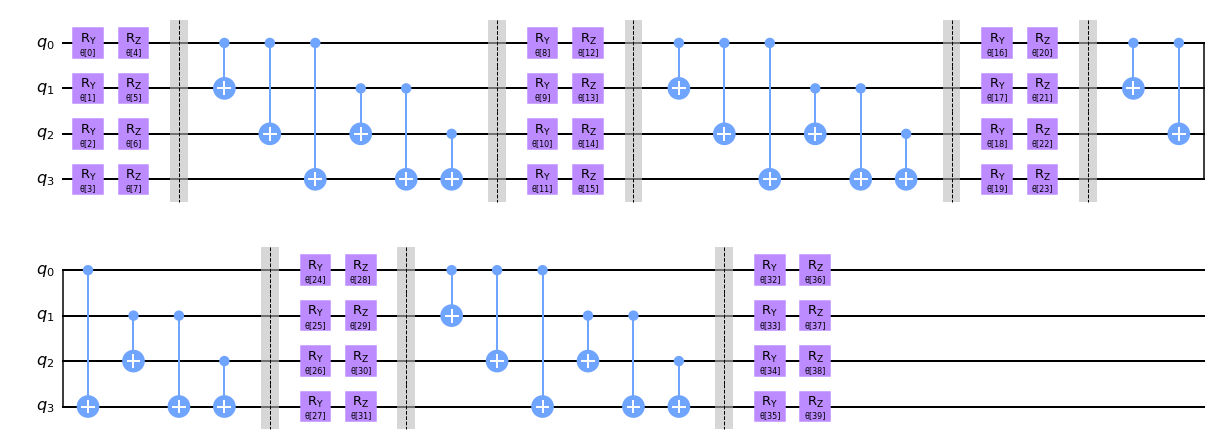

In [2]:
n_qubits = 4

encoding = RawFeatureVector(16)

ansatz = EfficientSU2(n_qubits, entanglement='full', reps=4, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")
ansatz.decompose()
qc = encoding.compose(ansatz)
qc.measure_all()
ansatz.decompose().draw(output="mpl")

In [3]:
def get_encode(file, type_ENC):

    """
    Funcao responsavel pelo encoding (amplitude)
    """
    if type_ENC.lower() == "amplitude":

        data_ENC = np.genfromtxt(file, delimiter=";")

    else:
        return None

    return data_ENC

In [4]:
train_data = get_encode(DIR_val_train, "amplitude")
train_labels = np.genfromtxt(DIR_cls_train, delimiter=";")

test_data = get_encode(DIR_val_test, "amplitude")
test_labels = np.genfromtxt(DIR_cls_test, delimiter=";")

In [5]:
def circuit_parameters(encoding, ansatz, x, thetas, self_encoding=False):
    parameters = {}
    if self_encoding:
        for i, p in enumerate(list(encoding.parameters)):
            parameters[p] = x[i]
    else:
        for i, p in enumerate(list(encoding.ordered_parameters)):
            parameters[p] = x[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = thetas[i]
    return parameters

In [6]:
def train(qc, encoding, ansatz, train_data, train_labels, self_encoding=False, lr=None, initial_point=None):
        # Callback function for optimiser for plotting purposes
        def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

        parameters = []
        costs = []
        evaluations = []

        if lr is not None:
                optimizer = SPSA(maxiter=200 , learning_rate=lr, perturbation=0.01, callback=store_intermediate_result)
        else:
                optimizer = SPSA(maxiter=200, callback=store_intermediate_result)

        if initial_point is not None:
                initial_point = initial_point
        else:      
                initial_point = np.random.random(ansatz.num_parameters)

        objective_function = lambda variational: cost_function(qc,encoding, ansatz,
                train_data, train_labels, variational, self_encoding=self_encoding)
        
        # Run the optimization
        opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

        return opt_var, opt_value , parameters, costs, evaluations 

## Mean Square error

### Multi Qubit exp val

$$Cost() = \frac{1}{N}\sum (y-\hat{y})^2$$


In [7]:
train_labels_oh = train_labels
test_labels_oh = test_labels

In [8]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]
    
    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [classification(results.get_counts(c)) for c in circuits]
    #print(predictions)
    cost = np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost {cost}")
    return cost

In [9]:
#%%script echo skipping
def basis_states_probs(counts, shots=1024, decimal=False, n_qubits=1):
    
    """
    Retorna as probabilidades de cada estado
    """
    
    probs = []
   
    if decimal:
        basis_states = list(range(2**n_qubits))
    else:
        basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

    for b in basis_states:
        c = counts.get(b)
        if c is None:
            probs.append(0)
        else:
            probs.append(counts[b]/shots)
    
    return probs


def classification(counts, shots=1024, label=True):
    
    def count_ones(string):
        r = 0
        for char in string:
            if char == "1":
                r+=1
        return r
    
    def label_assign(exp_val):
        if exp_val >= 0:
            r = 1
        else:
            r = -1
        return r

    probs = basis_states_probs(counts, n_qubits=n_qubits)
    states = ["".join(seq) for seq in itr.product("01", repeat=n_qubits)]
    
    exp_val = 0
    for state, prob in zip(states, probs):
        #print(prob, state)
        exp_val += ((-1)**(count_ones(state)%2))*prob
    
    #print(f"Valor expectávlel {exp_val}, Label {label_assign(exp_val)} ")
    if label:
        #print(exp_val)
        return label_assign(exp_val)
    else:
        return exp_val
    
def loss_function(y,y_hat):
    #print(f"Loss {y}-{y_hat}**2")
    #print(f"Loss {(y-y_hat)**2}")
    return (y-y_hat)*(y-y_hat)

In [10]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

Cost 1.3
Cost 2.0
Cost 2.0
Cost 0.8
Cost 1.35
Cost 1.75
Cost 2.0
Cost 1.95
Cost 1.5
Cost 2.0
Cost 1.95
Cost 1.9
Cost 2.9
Cost 1.45
Cost 1.8
Cost 1.45
Cost 2.55
Cost 1.7
Cost 1.7
Cost 1.7
Cost 1.25
Cost 2.0
Cost 1.95
Cost 2.1
Cost 0.8
Cost 2.0
Cost 1.95
Cost 1.75
Cost 1.95
Cost 2.0
Cost 1.3
Cost 1.3
Cost 1.2
Cost 2.0
Cost 1.95
Cost 1.95
Cost 1.95
Cost 1.75
Cost 2.3
Cost 1.9
Cost 1.95
Cost 1.9
Cost 1.95
Cost 2.0
Cost 2.0
Cost 1.6
Cost 2.0
Cost 1.9
Cost 1.45
Cost 1.45
Cost 1.95
Cost 1.8
Cost 1.85
Cost 2.7
Cost 1.45
Cost 2.0
Cost 2.2
Cost 0.8
Cost 3.25
Cost 1.55
Cost 3.3
Cost 2.0
Cost 2.1
Cost 2.0
Cost 2.0
Cost 2.05
Cost 2.05
Cost 2.0
Cost 2.05
Cost 2.0
Cost 2.0
Cost 1.1
Cost 2.0
Cost 2.0
Cost 2.0
Cost 2.0
Cost 2.05
Cost 2.0
Cost 2.1
Cost 2.0
Cost 2.0
Cost 2.95
Cost 2.0
Cost 2.0
Cost 0.95
Cost 2.0
Cost 2.5
Cost 2.0
Cost 1.95
Cost 1.9
Cost 2.0
Cost 1.9
Cost 0.85
Cost 2.0
Cost 0.65
Cost 0.6
Cost 0.9
Cost 0.55
Cost 1.15
Cost 0.6
Cost 1.0
Cost 1.15
Cost 0.35
Cost 1.05
Cost 1.0
Cost 1.05
Cost 0

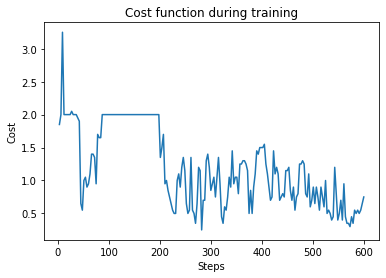

In [11]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("Cost function during training")
plt.show()

In [12]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]
    #print(circuits)

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    prediction = [classification(results.get_counts(c)) for c in circuits]
    #print(prediction)
    #print(labels)
    #prediction = [0 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(labels)
    print(prediction)
    for i, p in enumerate(prediction):
        #if (p and labels[i]) or (not p and not labels[i]):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [13]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

[-1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.
 -1. -1. -1. -1.  1.  1.]
[-1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1]
Test set accuracy - 0.7916666666666666


## Cross Entropy Loss

### Parity method

In [14]:
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

In [15]:
def parity_classification(counts, shots=1024):
    probs = np.zeros(2)
    for bitstring, counts in counts.items():
        hw_parity = hamming_weight_parity(bitstring)
        probs[hw_parity] += counts/shots
    
    return probs
def hamming_weight_parity(bitstring):
    hamming_weight = sum([int(k) for k in bitstring])
    return hamming_weight % 2

def loss_function(y,y_hat):
    #print(y_hat)
    return np.sum(y*np.log(y_hat))

In [16]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [parity_classification(results.get_counts(c)) for c in circuits]
    
    cost = -np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost: {cost}")
    
    return cost

In [17]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

Cost: 0.7411702650090928
Cost: 0.8823392782044447
Cost: 0.8365495022897047
Cost: 0.6894486260088627
Cost: 0.7461509289121754
Cost: 0.7903196106817859
Cost: 0.7203141517993769
Cost: 0.7688315336310986
Cost: 0.8463893086162422
Cost: 0.7936372465478179
Cost: 0.8699727751375622
Cost: 0.7561005808812608
Cost: 0.7501245645265646
Cost: 0.7365546046805532
Cost: 0.7383376778747361
Cost: 0.8540460090233797
Cost: 0.7421759720209783
Cost: 0.7016241802478561
Cost: 0.7853551720379751
Cost: 0.8187720909608543
Cost: 0.6965558932652585
Cost: 0.7952418848733053
Cost: 0.896085882087036
Cost: 0.7396951899018008
Cost: 0.7617832557672575
Cost: 0.7007189878233046
Cost: 0.7302578270575631
Cost: 0.8286770857524614
Cost: 0.777832833175693
Cost: 0.7334306489574225
Cost: 0.7826283320692211
Cost: 0.7357106587461174
Cost: 0.6944957787614264
Cost: 0.8687388416775509
Cost: 0.7007989513257066
Cost: 0.8768070087275742
Cost: 0.8314044239304408
Cost: 0.6466404409232099
Cost: 0.7623944039746344
Cost: 0.852173795871758
Cos

Cost: 0.5008329738334746
Cost: 0.5271244737753245
Cost: 0.4844137796985864
Cost: 0.5172796055430683
Cost: 0.5049532417337207
Cost: 0.4803693640654503
Cost: 0.5095002549866672
Cost: 0.5017857956901738
Cost: 0.4767922028171928
Cost: 0.5153564013239018
Cost: 0.5086664575647
Cost: 0.47523601772712193
Cost: 0.5042360126439037
Cost: 0.48375186409012494
Cost: 0.4790513813835746
Cost: 0.5109032826872536
Cost: 0.4800736785719736
Cost: 0.47544241034819434
Cost: 0.5319854374504589
Cost: 0.5104613609026565
Cost: 0.4703483700709651
Cost: 0.5082367715018918
Cost: 0.4993703733465251
Cost: 0.4735168135297485
Cost: 0.5442203570723373
Cost: 0.5323722887556837
Cost: 0.46876826572711555
Cost: 0.5136720242169075
Cost: 0.48004732257422644
Cost: 0.46877420753852644
Cost: 0.5292375752450349
Cost: 0.49908189926643837
Cost: 0.468407766745227
Cost: 0.48198417230850304
Cost: 0.4961835049375116
Cost: 0.4675097887878927
Cost: 0.4943771279657918
Cost: 0.5057579916766339
Cost: 0.47036489939407433
Cost: 0.493456806472

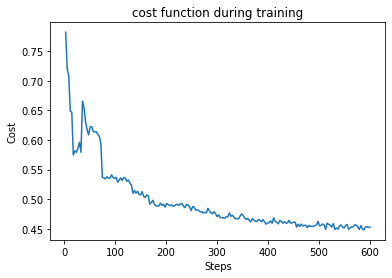

In [18]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [19]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    probs = [parity_classification(results.get_counts(c)) for c in circuits]
    prediction = [-1 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(labels)
    print(prediction)
    for i, p in enumerate(prediction):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [20]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

[-1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.
 -1. -1. -1. -1.  1.  1.]
[-1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1]
Test set accuracy - 0.8333333333333334


In [21]:
print(len(train_data))

80
